In [1]:
from google.cloud import bigquery
import operator
import networkx as nx
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt

In [2]:
G = nx.Graph()
client = bigquery.Client.from_service_account_json(
        'My Project-c23185ac100b.json')
client.project

'hardy-moon-199316'

In [3]:
query_word = "operating-system"

In [4]:
query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()

bigrams = []
gram = 2
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)
print(fdist.most_common(30))
associated_words = []
for comb in fdist.most_common(30):
    if query_word in comb[0]:
        associated_words.append(comb[0][comb[0].index(query_word) - 1])
        

[(('linux', 'operating-system'), 514), (('c', 'operating-system'), 490), (('operating-system', 'kernel'), 459), (('process', 'operating-system'), 432), (('c', 'linux'), 340), (('assembly', 'operating-system'), 335), (('memory-management', 'operating-system'), 328), (('multithreading', 'operating-system'), 312), (('linux-kernel', 'operating-system'), 286), (('unix', 'operating-system'), 264), (('windows', 'operating-system'), 248), (('python', 'operating-system'), 244), (('c++', 'c'), 158), (('macos', 'operating-system'), 155), (('operating-system', 'filesystems'), 154), (('memory', 'operating-system'), 151), (('operating-system', 'fork'), 141), (('operating-system', 'paging'), 131), (('java', 'operating-system'), 129), (('c++', 'operating-system'), 127), (('x86', 'operating-system'), 126), (('operating-system', 'scheduling'), 116), (('operating-system', 'system-calls'), 113), (('operating-system', 'x86'), 112), (('linux', 'unix'), 110), (('linux', 'linux-kernel'), 104), (('file', 'oper

In [5]:
associated_words


['linux',
 'c',
 'kernel',
 'process',
 'assembly',
 'memory-management',
 'multithreading',
 'linux-kernel',
 'unix',
 'windows',
 'python',
 'macos',
 'filesystems',
 'memory',
 'fork',
 'paging',
 'java',
 'c++',
 'x86',
 'scheduling',
 'system-calls',
 'x86',
 'file',
 'android',
 'virtual-memory']

In [6]:
correlation = []
for word in associated_words:
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 2
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    strong_words_temp = []
    
    for comb in fdist.most_common(20):
        if word in comb[0]:
            strong_words_temp.append(comb[0][comb[0].index(word) - 1]) 
            if comb[0][comb[0].index(word) - 1]  == query_word or (word != comb[0][comb[0].index(word) - 1]) and comb[0][comb[0].index(word) - 1] in associated_words:
                correlation.append(word)
    print(word, strong_words_temp)
print(correlation)

linux ['bash', 'c', 'c++', 'python', 'shell', 'java', 'php', 'ubuntu', 'unix', 'linux-kernel', 'gcc', 'windows', 'sockets', 'apache', 'mysql', 'multithreading', 'android']
c []
kernel ['linux-kernel', 'linux', 'operating-system', 'driver', 'kernel-module', 'linux-device-driver', 'windows']
process ['c#', 'linux']
assembly ['x86', 'c', 'mips', 'gcc', 'arm', 'linux', 'nasm', 'c++', 'x86-64', 'masm', 'arrays', 'x86-16', 'gdb', 'windows']
memory-management ['memory', 'c++', 'memory-leaks', 'objective-c', 'c', 'ios', 'pointers', 'java', 'linux', 'android', 'garbage-collection', 'malloc', 'iphone', 'arrays', 'linux-kernel', 'c#']
multithreading ['java', 'c#', 'c++', 'android', 'python', '.net', 'c', 'concurrency', 'sockets', 'linux', 'c++11', 'wpf', 'thread-safety', 'asynchronous', 'pthreads', 'qt', 'synchronization', 'swing']
linux-kernel ['linux', 'linux-device-driver', 'kernel', 'c', 'kernel-module', 'memory-management', 'arm', 'operating-system', 'embedded-linux', 'android', 'driver', 'a

In [7]:
set(correlation)

{'android',
 'assembly',
 'c++',
 'file',
 'filesystems',
 'fork',
 'java',
 'kernel',
 'linux',
 'linux-kernel',
 'macos',
 'memory',
 'memory-management',
 'multithreading',
 'paging',
 'process',
 'python',
 'scheduling',
 'system-calls',
 'unix',
 'virtual-memory',
 'windows',
 'x86'}

In [8]:
# take these strong words and then use the with initial word and use them together to find one bigger ngram.
most_frequent_3_comb = {}
for word in set(correlation):
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a and tags like @b
        limit 1000000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%"),
        bigquery.ScalarQueryParameter(
            'b', 'STRING', "%"+query_word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 3
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    
    for l in fdist.most_common(5):
        for w in l[0]:
            if w not in set(correlation):
                break
            if w in most_frequent_3_comb:
                most_frequent_3_comb[w] += 1
            else:
                most_frequent_3_comb[w] = 1
print(most_frequent_3_comb)
    

{'process': 10, 'linux': 22, 'windows': 12, 'python': 8, 'c++': 5, 'memory-management': 13, 'memory': 5, 'assembly': 7, 'x86': 4, 'linux-kernel': 8, 'macos': 4, 'unix': 7, 'file': 6, 'multithreading': 7, 'java': 7, 'android': 6}


In [9]:
most_frequent_comb = sorted(most_frequent_3_comb.items(), key=operator.itemgetter(1), reverse=True)[0][0]

In [10]:
most_frequent_3_comb

{'android': 6,
 'assembly': 7,
 'c++': 5,
 'file': 6,
 'java': 7,
 'linux': 22,
 'linux-kernel': 8,
 'macos': 4,
 'memory': 5,
 'memory-management': 13,
 'multithreading': 7,
 'process': 10,
 'python': 8,
 'unix': 7,
 'windows': 12,
 'x86': 4}

In [11]:
# i can obviosuly go directly but then that would not be the right way to navigate to that tag. I have to find what is the
# right link to get to that word that actually makes sense. for example data structure, tree, binary-search-tree would be 
# right link rather than data structure, java, binary-search-tree

# I can get to binary search tree faster thru tree than going thru graph. 

In [12]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b
    limit 1000000
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 3
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [13]:
fdist.most_common(10)
# what if all of them have the same score and some of them contains both the words then which word do you choose? 

[(('c', 'linux', 'operating-system'), 184),
 (('linux', 'linux-kernel', 'operating-system'), 102),
 (('linux', 'unix', 'operating-system'), 81),
 (('linux-kernel', 'operating-system', 'kernel'), 65),
 (('linux', 'operating-system', 'kernel'), 44),
 (('c', 'linux', 'unix'), 42),
 (('linux', 'windows', 'operating-system'), 38),
 (('linux', 'process', 'operating-system'), 37),
 (('linux', 'operating-system', 'linux-kernel'), 34),
 (('c++', 'c', 'linux'), 32)]

In [14]:
other_comb_word = [x for x in fdist.most_common(5)[0][0] if x not in [most_frequent_comb, query_word]][0]
other_comb_word

'c'

In [15]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 4
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [16]:
fdist.most_common(5)

[(('c', 'linux', 'unix', 'operating-system'), 37),
 (('c', 'linux', 'linux-kernel', 'operating-system'), 31),
 (('c++', 'c', 'linux', 'operating-system'), 17),
 (('c', 'linux', 'operating-system', 'fork'), 16),
 (('c', 'linux', 'operating-system', 'system-calls'), 14)]

In [17]:
query = """
    SELECT title, score
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [18]:
results = query_job.result()
for row in results:
    print(row.title, row.score)

What Languages are Windows, Mac OS X and Linux written in? 207
Why is Linux called a monolithic kernel? 174
PHP script - detect whether running under linux or Windows? 114
Spinlock versus Semaphore 98
Locking Executing Files: Windows does, Linux doesn't. Why? 75
dup2 / dup - why would I need to duplicate a file descriptor? 60
Maximum number of processes in linux 54
Check the open FD limit for a given process in Linux 49
Time waste of execv() and fork() 42
Who decides the sizeof any datatype or structure (depending on 32 bit or 64 bit)? 41
What parts of Linux kernel can I read for fun? 36
Is OSX a POSIX OS? 36
Why are "Executable files" operating system dependent? 35
How closely are Mac OS X and BSD related? 35
Windows CE vs Embedded Linux 32
stdout thread-safe in C on Linux? 32
Is it true that fork() calls clone() internally? 31
Why is memory allocation for processes slow and can it be faster? 26
Convert physical address to virtual in Linux and read its content 24
Does Linux use x86 CP

Linux system does not allow creation of sockets because of "Too many open files" *even after a reboot* 2
Shell seems to recognize commands but doesn't execute them 2
Bare bones OS kernel programming 2
How the OS handles python and subprocesses of a python script...? 2
Processors and virtual/physical addresses 2
Data is not written into /proc file 2
Pushing code towards kernel or user space, for performance reasons? 2
Adding a new system call to linux kernel doesn't seem to work 2
linux kernel code ">>" operator 2
ARM - What are the differences in the context switch handling, if IRQ happens in USR mode vs SVC mode? 2
How does an application code talk to the kernel's code? 2
process exit and impact on threads 2
size of pointer is always equal to size of int in C compiler . Is it correct? 2
Multiple child creation with fork() in Linux 2
Determine state of a process 2
Is there any way to excute a command as a specific user in Python? 2
What is the difference between ps and ps -e command in

In [19]:
query = """
    SELECT tags, title
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a 
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()
for row in results:
    print(row.tags, row.title)

In [21]:
# there are many ways to miss the most important questions just because there was no tag associated with it. 
# This way I might miss many of the important questions on 2-3-4 trees. 

In [22]:
query = """
    SELECT tag_name, count
    FROM `bigquery-public-data.stackoverflow.tags`
    where tag_name like "%data-structure%"
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [23]:
results = query_job.result()


In [24]:
for row in results:
    print(row.tag_name, row.count)

perl-data-structures 397
data-structures 20723


In [25]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [28]:
import numpy as np
import csv
import os
if not os.path.exists('data.csv'):
    results = query_job.result()
    with open('data.csv', 'w') as myfile:
        wr = csv.writer(myfile)
        for row in results:
            wr.writerow(row.tags.split("|"))

In [31]:
import csv 
import sys #used for passing in the argument
file_name = "data.csv" #filename is argument 1
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter=',')) #reads csv into a list of lists


/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


In [32]:
len(data)

15483377

In [35]:
from gensim.models import Word2Vec

In [36]:
b = Word2Vec(data, min_count=1000, size=200)

In [39]:
b.save("word2vec_model")

In [94]:
b.most_similar([ 'artificial-intelligence'], topn=20)

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('genetic-algorithm', 0.7181348204612732),
 ('path-finding', 0.6938122510910034),
 ('neural-network', 0.659702479839325),
 ('graph-algorithm', 0.6270614862442017),
 ('depth-first-search', 0.5898061990737915),
 ('graph-theory', 0.5874534845352173),
 ('breadth-first-search', 0.5869895815849304),
 ('computer-science', 0.5836610794067383),
 ('pseudocode', 0.5804481506347656),
 ('bayesian', 0.5632973909378052),
 ('mathematical-optimization', 0.5631980895996094),
 ('machine-learning', 0.5628211498260498),
 ('prediction', 0.550203800201416),
 ('classification', 0.5404967069625854),
 ('probability', 0.5374963879585266),
 ('nlp', 0.5372757315635681),
 ('algorithm', 0.529630184173584),
 ('decision-tree', 0.5294957756996155),
 ('game-physics', 0.5257804989814758),
 ('data-mining', 0.5222604274749756)]

In [43]:
X = b[b.wv.vocab]

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [57]:
X

array([[-1.4096309 , -1.917103  , -0.18124919, ...,  0.6314239 ,
        -0.5974228 , -0.8467964 ],
       [ 0.2878538 , -0.11880537,  0.19552912, ...,  0.4126739 ,
        -2.0449882 ,  1.62096   ],
       [ 0.07174768,  1.5574695 ,  0.041627  , ..., -1.047169  ,
        -0.7809817 ,  0.48368424],
       ...,
       [-0.72873235, -0.3787417 ,  0.1006001 , ..., -1.1431504 ,
        -0.32474852,  0.9253831 ],
       [-0.30565065, -0.56117797, -0.08763129, ..., -0.96584505,
        -0.5575447 , -0.31782407],
       [-0.80091524,  0.04073753,  0.5322995 , ...,  0.29004335,
         0.5360779 ,  0.16299538]], dtype=float32)

In [103]:
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(300, distance=nltk.cluster.util.cosine_distance)

In [104]:
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)


KeyboardInterrupt: 

In [48]:
words = list(b.wv.vocab)
word_cluster = {}
for i, word in enumerate(words):  
    word_cluster[word] = assigned_clusters[i]
   

In [92]:
from collections import defaultdict

v = defaultdict(list)

for key, value in sorted(word_cluster.items()):
    v[value].append(key)

In [93]:
v

defaultdict(list,
            {0: ['deserialization',
              'dtd',
              'jaxb',
              'linq-to-xml',
              'marshalling',
              'sax',
              'saxon',
              'serialization',
              'unmarshalling',
              'xml',
              'xml-namespaces',
              'xml-parsing',
              'xml-serialization',
              'xmldocument',
              'xmlserializer',
              'xpath',
              'xquery',
              'xsd',
              'xsd-validation',
              'xslt',
              'xslt-1.0',
              'xslt-2.0'],
             1: ['app-engine-ndb',
              'bottle',
              'celery',
              'cgi',
              'cherrypy',
              'django',
              'django-admin',
              'django-authentication',
              'django-celery',
              'django-cms',
              'django-forms',
              'django-haystack',
              'django-models',
           

In [118]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1000, max_iter=500, n_init=20 )
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=1000, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [119]:
labels = kmeans.labels_

In [120]:
word_cluster1 = {}
for i, word in enumerate(words):  
    word_cluster1[word] = labels[i]

In [121]:
from collections import defaultdict

v1 = defaultdict(list)

for key, value in sorted(word_cluster1.items()):
    v1[value].append(key)

In [122]:
v1

defaultdict(list,
            {506: ['.htaccess'],
             247: ['.net',
              '.net-2.0',
              '.net-3.5',
              '.net-4.0',
              '.net-4.5',
              'c#-2.0',
              'c#-3.0',
              'c#-4.0'],
             826: ['.net-assembly', 'assemblies'],
             487: ['.net-core', 'asp.net-core'],
             344: ['2d',
              '3d',
              'accelerometer',
              'angle',
              'collision',
              'collision-detection',
              'coordinates',
              'distance',
              'graphics',
              'interpolation',
              'intersection',
              'physics',
              'point',
              'rotation',
              'trigonometry'],
             471: ['32-bit', '32bit-64bit', '64bit'],
             384: ['abap',
              'cobol',
              'dump',
              'ibm-midrange',
              'powerbuilder',
              'trace',
              'vb6'],
    

In [115]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# k means determine k
distortions = []
K = range(1,1000)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [1410]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
 

# generate the linkage matrix
Z = linkage(X, 'ward')


In [1412]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.2384684021301623

In [1381]:
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

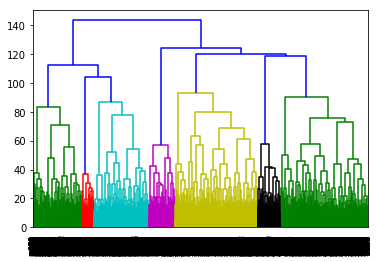

In [1382]:
plt.show()

array([996.        , 997.        ,   2.15974402,   2.        ])

In [1428]:
b.wv.

{'asp.net': <gensim.models.keyedvectors.Vocab at 0x24c50cb70>,
 'code-behind': <gensim.models.keyedvectors.Vocab at 0x24c50cbe0>,
 'javascript': <gensim.models.keyedvectors.Vocab at 0x24c50cc18>,
 'ajax': <gensim.models.keyedvectors.Vocab at 0x24c50cba8>,
 'c++': <gensim.models.keyedvectors.Vocab at 0x24c50c7b8>,
 'linux': <gensim.models.keyedvectors.Vocab at 0x24c50c748>,
 'php': <gensim.models.keyedvectors.Vocab at 0x24c50c6a0>,
 'mysql': <gensim.models.keyedvectors.Vocab at 0x24c50c7f0>,
 'jquery': <gensim.models.keyedvectors.Vocab at 0x24c50cc50>,
 'html': <gensim.models.keyedvectors.Vocab at 0x24c50cc88>,
 'css3': <gensim.models.keyedvectors.Vocab at 0x24c50ccc0>,
 'css-animations': <gensim.models.keyedvectors.Vocab at 0x24c50ccf8>,
 'angularjs': <gensim.models.keyedvectors.Vocab at 0x24c50cd30>,
 'angular': <gensim.models.keyedvectors.Vocab at 0x24c50cd68>,
 'protractor': <gensim.models.keyedvectors.Vocab at 0x24c50cda0>,
 'python': <gensim.models.keyedvectors.Vocab at 0x24c50cdd

In [1427]:
len(Z)

3978

In [1418]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

NameError: name 'fancy_dendrogram' is not defined

In [1419]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

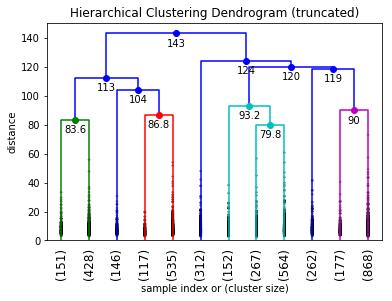

In [1420]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

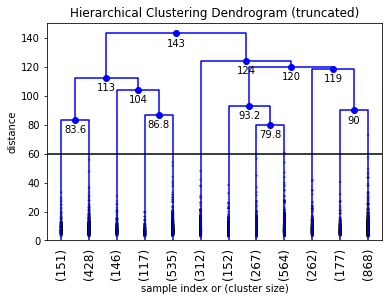

In [1421]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=60,  # plot a horizontal cut-off line
)
plt.show()

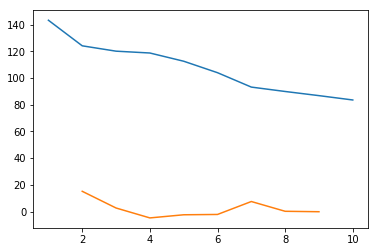

clusters: 2


In [1423]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print( "clusters:", k)

In [ ]:
#as the reputation increases, find out the tags of the questions being asked by these users. Also find out the answers
# frequency with which they ask question and answer. and what is the general trend of the scores of these answers. 
# is there a trend that we see? So that we can use thes trend and then predict what type of questions to show to the user. 
# for him to answer. Or just read with the answer of these questions. 